<a href="https://colab.research.google.com/github/uruba24/Predicting-House-Prices-Using-California-Housing-Dataset/blob/main/Task_4_Predicting_House_Prices_Using_the_California_Housing_Dataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


In [ ]:
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target, name="MEDHOUSEVAL")

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
X = X.apply(pd.to_numeric, errors='coerce')  # Convert everything to numeric
X = X.fillna(0)  # Replace any NaNs with 0 or mean if you prefer

In [ ]:
X_np = X.values
y_np = y.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

In [ ]:
class LinearRegressionScratch:
    def fit(self, X, y, lr=0.01, epochs=1000):
        self.theta = np.zeros(X.shape[1] + 1)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        for _ in range(epochs):
            gradients = 2 / len(X) * X_b.T.dot(X_b.dot(self.theta) - y)
            self.theta -= lr * gradients

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.theta)


In [ ]:
from collections import Counter

class DecisionTreeRegressor:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def mse(self, y):
        return np.mean((y - np.mean(y))**2)

    def best_split(self, X, y):
        best_mse = float("inf")
        split_idx, split_val = None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left = y[X[:, feature] <= t]
                right = y[X[:, feature] > t]
                if len(left) < self.min_samples_split or len(right) < self.min_samples_split:
                    continue
                mse_val = (len(left) * self.mse(left) + len(right) * self.mse(right)) / len(y)
                if mse_val < best_mse:
                    best_mse, split_idx, split_val = mse_val, feature, t
        return split_idx, split_val

    def build_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(y) < self.min_samples_split or len(set(y)) == 1:
            return np.mean(y)
        split_idx, split_val = self.best_split(X, y)
        if split_idx is None:
            return np.mean(y)
        left_mask = X[:, split_idx] <= split_val
        left = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self.build_tree(X[~left_mask], y[~left_mask], depth + 1)
        return (split_idx, split_val, left, right)

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict_sample(self, x, node):
        if not isinstance(node, tuple):
            return node
        idx, val, left, right = node
        return self.predict_sample(x, left) if x[idx] <= val else self.predict_sample(x, right)

    def predict(self, X):
        return np.array([self.predict_sample(x, self.tree) for x in X])

class RandomForestScratch:
    def __init__(self, n_estimators=10, max_depth=5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
     X = np.array(X)  # Ensures X is NumPy
     y = np.array(y)
     for _ in range(self.n_estimators):
         indices = np.random.choice(len(X), len(X), replace=True)
         X_sample, y_sample = X[indices], y[indices]
         tree = DecisionTreeRegressor(max_depth=self.max_depth)
         tree.fit(X_sample, y_sample)
         self.trees.append(tree)

    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(preds, axis=0)


In [ ]:
class XGBoostScratch:
    def __init__(self, n_estimators=10, lr=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.lr = lr
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        pred = np.zeros_like(y)
        for _ in range(self.n_estimators):
            residual = y - pred
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residual)
            update = tree.predict(X)
            pred += self.lr * update
            self.trees.append(tree)

    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for tree in self.trees:
            pred += self.lr * tree.predict(X)
        return pred


In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def r2_score(y_true, y_pred):
    total = np.sum((y_true - np.mean(y_true)) ** 2)
    residual = np.sum((y_true - y_pred) ** 2)
    return 1 - residual / total



In [ ]:
models = {
    "Linear Regression": LinearRegressionScratch(),
    "Random Forest": RandomForestScratch(n_estimators=10),
    "XGBoost": XGBoostScratch(n_estimators=10)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name}: RMSE={rmse(y_test, y_pred):.4f}, R²={r2_score(y_test, y_pred):.4f}")

Linear Regression: RMSE=0.7440, R²=0.5775
Random Forest: RMSE=0.6876, R²=0.6392
XGBoost: RMSE=1.0814, R²=0.1075


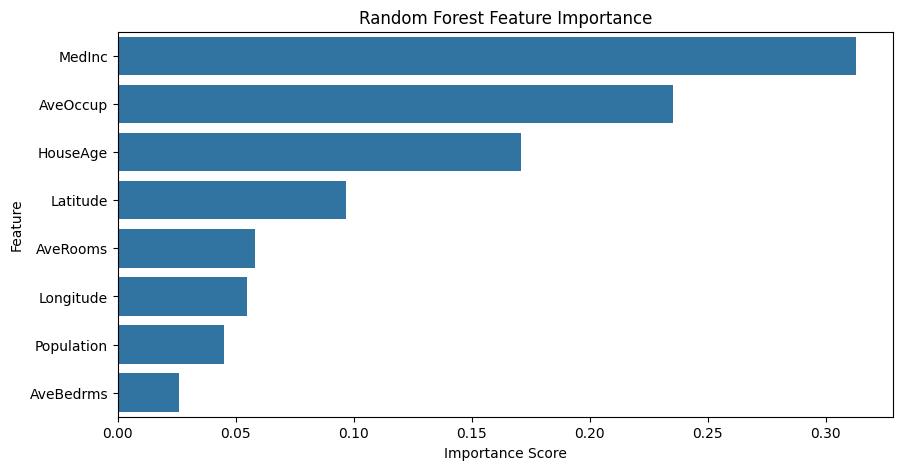

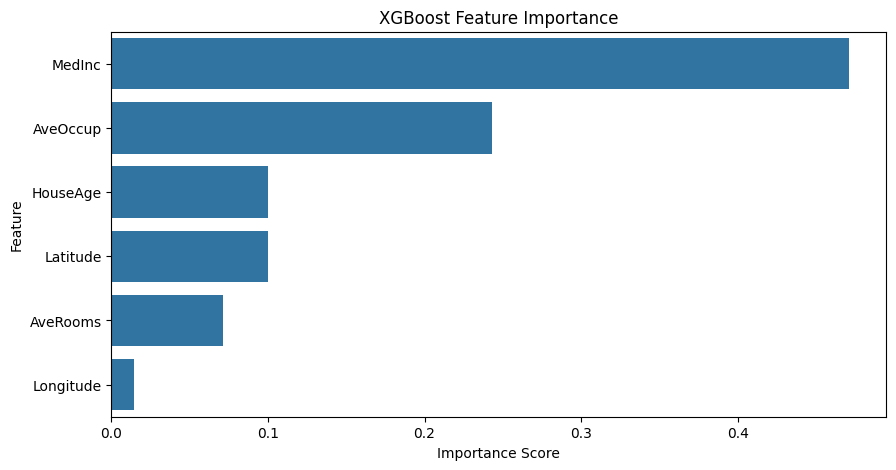

In [ ]:
def feature_importance_from_trees(trees, feature_names):
    importance = Counter()
    for tree in trees:
        stack = [tree.tree]
        while stack:
            node = stack.pop()
            if isinstance(node, tuple):
                idx, _, left, right = node
                importance[idx] += 1
                stack.extend([left, right])
    total = sum(importance.values())
    return {feature_names[k]: v / total for k, v in importance.items()}

rf_importance = feature_importance_from_trees(models["Random Forest"].trees, california.feature_names)
xgb_importance = feature_importance_from_trees(models["XGBoost"].trees, california.feature_names)

def plot_importance(importance, title):
    items = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    features, scores = zip(*items)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=scores, y=features)
    plt.title(title)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()

plot_importance(rf_importance, "Random Forest Feature Importance")
plot_importance(xgb_importance, "XGBoost Feature Importance")
